In [3]:
import h5py
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torch.nn.utils import clip_grad_norm_
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import Resize
import torch.nn.functional as F
import torchvision.transforms as T


/home/ferroelectric/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/ferroelectric/.local/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator12recordStreamERKNS_7DataPtrENS0_10CUDAStreamE
  warn(f"Failed to load image Python extension: {e}")


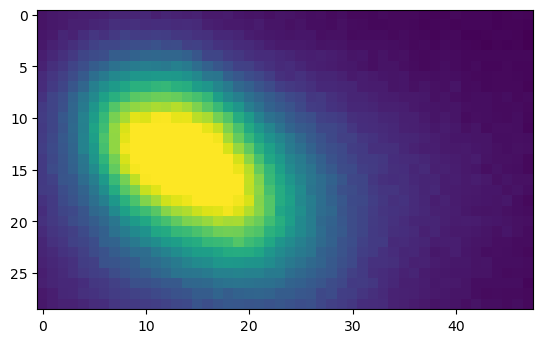

In [4]:

class HDF5Dataset(Dataset):
    def __init__(self, file_path, data_key):
        self.file_path = file_path
        self.data_key = data_key

        # Open the HDF5 file
        self.h5file = h5py.File(file_path, 'r')
        # Get the HDF5 dataset
        self.data = self.h5file[data_key][:]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
       
        image = self.data[index]
        image= torch.from_numpy(image)
        
        image=image/image.max()
    
        # image = F.interpolate(image.unsqueeze(0).unsqueeze(0), size=(32, 32), mode='bilinear', align_corners=False)
        # image = image.squeeze()
      
        return image

# Specify the path to the HDF5 file and the dataset key
file_path = '/home/ferroelectric/RHEED_paper/m3_learning/m3_learning/papers/2023_RHEED_PLD_SrTiO3/Datasets/test6_gaussian_fit_parameters_all-04232023.h5'
dataset_key = 'growth_1/spot_2/raw_image'



# Create an instance of the HDF5Dataset
dataset = HDF5Dataset(file_path, dataset_key)

# Create a data loader for the dataset
batch_size = 300
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)



plt.imshow(dataset[0])
plt.show()



In [22]:
class LeNet5(nn.Module):
    def __init__(self, func, num_classes,flag=False):
        super(LeNet5, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 4, stride = 4))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(48, 48)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(48, 24)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(24, num_classes)
        self.func = func
        self.flag=flag

    def forward(self, x):
        x=x.float()
        
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        embedding = self.fc2(out)
        embedding2=self.func(embedding)
        # print(out[0])
        
        if self.flag==True:
            return out, embedding, embedding2 
        
        return embedding2

In [6]:
class GaussianGenerator(nn.Module):
    def __init__(self, img_dim):
        super(GaussianGenerator, self).__init__()
        self.img_dim = img_dim

    def forward(self, params):
        batch_size = params.shape[0]
        mean_x, mean_y, cov_x, cov_y, theta = params.unbind(dim=-1)
        cov_x = torch.clamp(cov_x, min=1e-9)
        cov_y = torch.clamp(cov_y, min=1e-9)

        x = torch.arange(self.img_dim[1], dtype=torch.float32).reshape(-1, 1).repeat(1, self.img_dim[0]).to(params.device)
        y = torch.arange(self.img_dim[0], dtype=torch.float32).reshape(1, -1).repeat(self.img_dim[1], 1).to(params.device)

        x = x.repeat(batch_size, 1, 1)
        y = y.repeat(batch_size, 1, 1)

        rota_matrix = torch.stack([torch.cos(theta), -torch.sin(theta), torch.sin(theta), torch.cos(theta)], dim=-1)
        rota_matrix = rota_matrix.view(batch_size, 2, 2)

        xy = torch.stack([x - mean_x.view(-1, 1, 1), y - mean_y.view(-1, 1, 1)], dim=-1)
        xy = torch.einsum('bijk,bkl->bijl', xy, rota_matrix)

        img = torch.exp(-0.5 * (xy[:, :, :, 0]**2 / (cov_x.view(-1, 1, 1)**2 ) + xy[:, :, :, 1]**2 / (cov_y.view(-1, 1, 1)**2 )))

        

        return img.unsqueeze(1)

In [7]:
class HigherOrderLoss(nn.Module):
    def __init__(self, order=3):
        super(HigherOrderLoss, self).__init__()
        self.order = order

    def forward(self, predicted, target):
        # Calculate the higher-order loss
        loss = torch.pow(torch.abs(predicted - target), self.order).mean()
        return loss

In [17]:
net = LeNet5(GaussianGenerator((48,29)).float(),5,flag=True).cuda().float()


file_path = '/home/ferroelectric/RHEED_paper/m3_learning/m3_learning/papers/2023_RHEED_PLD_SrTiO3/Datasets/test6_gaussian_fit_parameters_all-04232023.h5'
dataset_key = 'growth_1/spot_2/raw_image'
dataset = HDF5Dataset(file_path, dataset_key)
# Create a data loader for the dataset
dataloader = DataLoader(dataset, batch_size=1000, shuffle=True,num_workers=0)
#   print(f'RUN {i}')
i=0
while i<10:
    for images in dataloader:
        images = images.unsqueeze(1).cuda()
        output1, output2, output3 = net(images)
        print(output1)
        print(output2)
        print(output3)
        print(i)
        i+=1



tensor([[0.0000, 0.0000, 0.1140,  ..., 0.2728, 0.0000, 0.0000],
        [0.0000, 0.3160, 0.1530,  ..., 0.6811, 0.0300, 0.0000],
        [0.0000, 0.0453, 0.1970,  ..., 0.4604, 0.0000, 0.0000],
        ...,
        [0.0000, 0.2992, 0.1495,  ..., 0.8487, 0.0000, 0.0000],
        [0.0000, 0.2615, 0.3015,  ..., 0.4639, 0.0000, 0.0000],
        [0.0000, 0.2913, 0.3019,  ..., 0.4736, 0.0000, 0.0000]],
       device='cuda:0', grad_fn=<ReluBackward0>)
tensor([[ 0.0433,  0.3130,  0.0993, -0.0083, -0.0348],
        [ 0.1157,  0.3496,  0.2462,  0.0888,  0.0379],
        [ 0.0846,  0.3103,  0.1443,  0.0778, -0.0102],
        ...,
        [ 0.2126,  0.4909,  0.2468,  0.0909, -0.0252],
        [ 0.1018,  0.3440,  0.1286, -0.0023,  0.0081],
        [ 0.1058,  0.3407,  0.1465,  0.0300,  0.0313]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.000

In [21]:

# for i in range(5):
net = LeNet5(GaussianGenerator((48,29)).float(),5).cuda().float()
criterion = nn.MSELoss()
# criterion=nn.CrossEntropyLoss()
# criterion = HigherOrderLoss(order=3)
best_loss = float('inf')
best_model_path = 'best-model.pt'

num_epochs = 100
lr=1e-9
from TrustRegion import TRCG
# optimizer = TRCG(net, 5, "cuda")



optimizer = optim.Adam(net.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, epochs=num_epochs, max_lr=1e-3, steps_per_epoch=len(data_loader))
file_path = '/home/ferroelectric/RHEED_paper/m3_learning/m3_learning/papers/2023_RHEED_PLD_SrTiO3/Datasets/test6_gaussian_fit_parameters_all-04232023.h5'
dataset_key = 'growth_1/spot_2/raw_image'
dataset = HDF5Dataset(file_path, dataset_key)
# Create a data loader for the dataset
data_loader = DataLoader(dataset, batch_size=1000, shuffle=True,num_workers=0)
#   print(f'RUN {i}')


from tqdm import tqdm

for epoch in range(num_epochs):
    running_loss = 0.0
    

    for images in tqdm(data_loader):
        
        images = images.unsqueeze(1)

        optimizer.zero_grad()
        outputs = net(images.cuda())
        
        
        loss = criterion(outputs.float(), images.cuda().float())  # compare outputs with input images for reconstruction
        loss.backward()
        clip_grad_norm_(net.parameters(), 1)

        optimizer.step()
        scheduler.step()

        running_loss += loss.item()
    average_loss = running_loss / len(data_loader)
        

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss}")
    
    if average_loss < best_loss:
        best_loss = average_loss
        # Save the current model
        torch.save(net.state_dict(), best_model_path)





  0%|          | 0/14 [00:00<?, ?it/s]


RuntimeError: Given input size: (16x2x7). Calculated output size: (16x0x2). Output size is too small

In [10]:
print()

tensor([[[0.1313, 0.1414, 0.1364,  ..., 0.1061, 0.1162, 0.1111],
         [0.1364, 0.1364, 0.1515,  ..., 0.1111, 0.1111, 0.1111],
         [0.1414, 0.1566, 0.1616,  ..., 0.1162, 0.1111, 0.1010],
         ...,
         [0.1515, 0.1717, 0.1919,  ..., 0.1515, 0.1515, 0.1212],
         [0.1465, 0.1667, 0.1768,  ..., 0.1364, 0.1313, 0.1212],
         [0.1465, 0.1566, 0.1616,  ..., 0.1364, 0.1465, 0.1364]]],
       dtype=torch.float64)


In [36]:


# for i in range(5):
net = LeNet5(GaussianGenerator((48,29)).float(),5).cuda().float()
criterion = nn.MSELoss()
# criterion=nn.CrossEntropyLoss()
# criterion = HigherOrderLoss(order=3)
best_loss = float('inf')
best_model_path = 'best-model.pt'

num_epochs = 100
lr=1e-6
from TrustRegion import TRCG
optimizer = TRCG(net, 5, "cuda")



# optimizer = optim.Adam(net.parameters(), lr=lr)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, epochs=num_epochs, max_lr=1e-3, steps_per_epoch=len(data_loader))
file_path = '/home/ferroelectric/RHEED_paper/m3_learning/m3_learning/papers/2023_RHEED_PLD_SrTiO3/Datasets/test6_gaussian_fit_parameters_all-04232023.h5'
dataset_key = 'growth_1/spot_2/raw_image'
dataset = HDF5Dataset(file_path, dataset_key)
# Create a data loader for the dataset
data_loader = DataLoader(dataset, batch_size=1000, shuffle=True,num_workers=0)
#   print(f'RUN {i}')

from tqdm import tqdm

for epoch in range(num_epochs):
    running_loss = 0.0
    
    train_loss=0
    total_num=0
    for images in tqdm(data_loader):
        
        images = images.unsqueeze(1).cuda()

        # optimizer.zero_grad()
        outputs = net(images.cuda())
        
        def closure(part, total, device):
            pred = net(images)
            pred = pred.to(torch.float32)
            loss = criterion(pred.cuda().float(), images.cuda().float())
            return loss

        # if closure is not None:
        loss, radius, cnt_compute, cg_iter = optimizer.step(closure)
        train_loss += loss * images.shape[0]
        total_num += images.shape[0]
        optimizer_name = "Trust Region CG"
        
        
        loss = criterion(outputs.float(), images.cuda().float())  # compare outputs with input images for reconstruction
        loss.backward()
        clip_grad_norm_(net.parameters(), 1)

        optimizer.step()
        # scheduler.step()

        running_loss += loss.item()
    average_loss = running_loss / len(data_loader)
        

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss}")
    
    if average_loss < best_loss:
        best_loss = average_loss
        # Save the current model
        torch.save(net.state_dict(), best_model_path)

  0%|          | 0/14 [00:01<?, ?it/s]



CG has issues !!!




RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.cuda.FloatTensor [24, 5]], which is output 0 of AsStridedBackward0, is at version 2; expected version 1 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

In [11]:
with torch.no_grad():
  dev=torch.device("cuda")
  data = next(iter(data_loader))
  data=data.unsqueeze(1)
  data_ = data.cpu()
  optimizer.zero_grad()
  outputs = net(data.to('cuda')).cpu()
  

In [12]:
data.shape

torch.Size([1000, 1, 29, 48])

In [13]:
path = '/home/ferroelectric/RHEED_paper/m3_learning/m3_learning/papers/2023_RHEED_PLD_SrTiO3/Datasets/test6_gaussian_fit_parameters_all-04232023.h5'
manual_im=[]
with h5py.File(path, 'r') as h5:
    for i in range(100):
        manual_im.append(h5['growth_1']['spot_2']['reconstructed_image'][i])
    

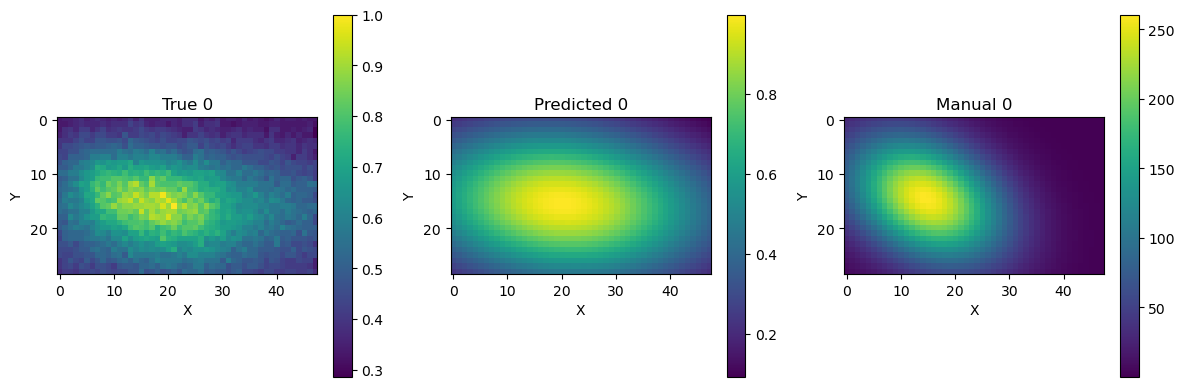

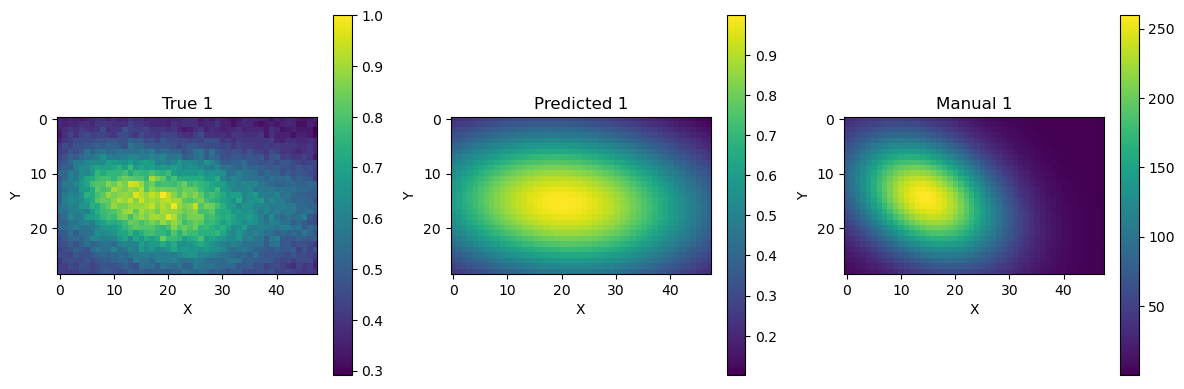

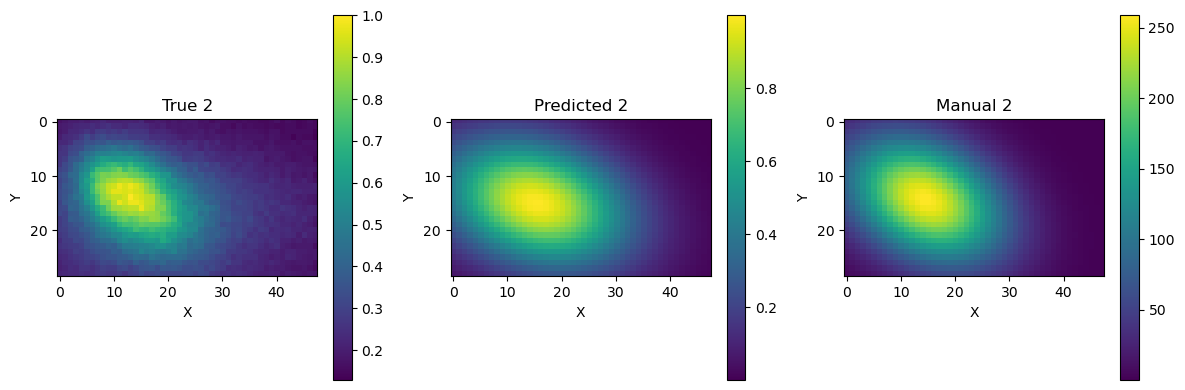

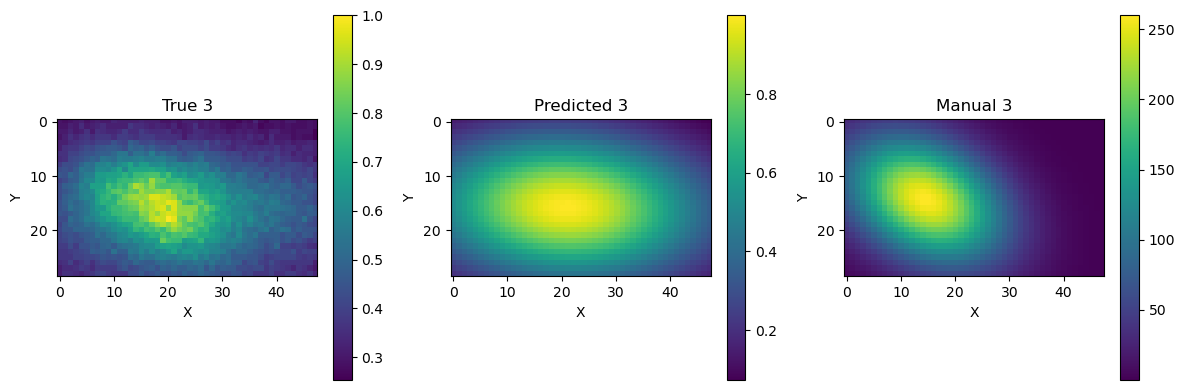

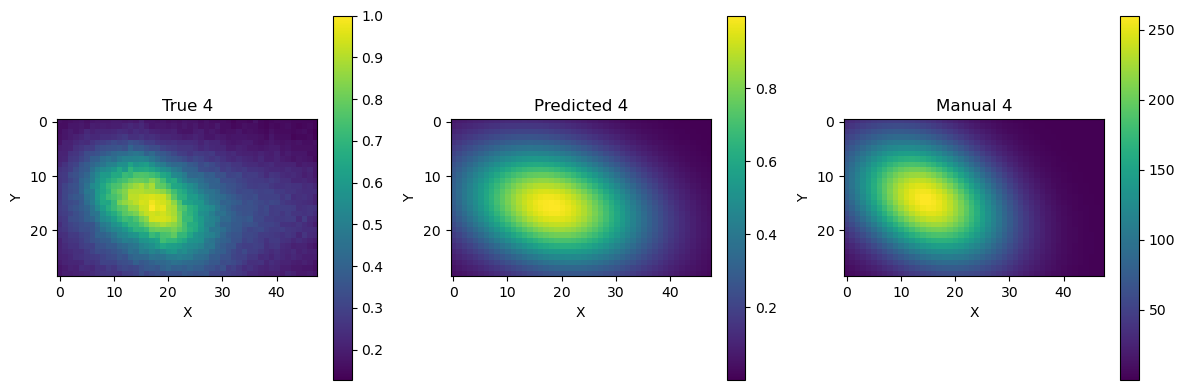

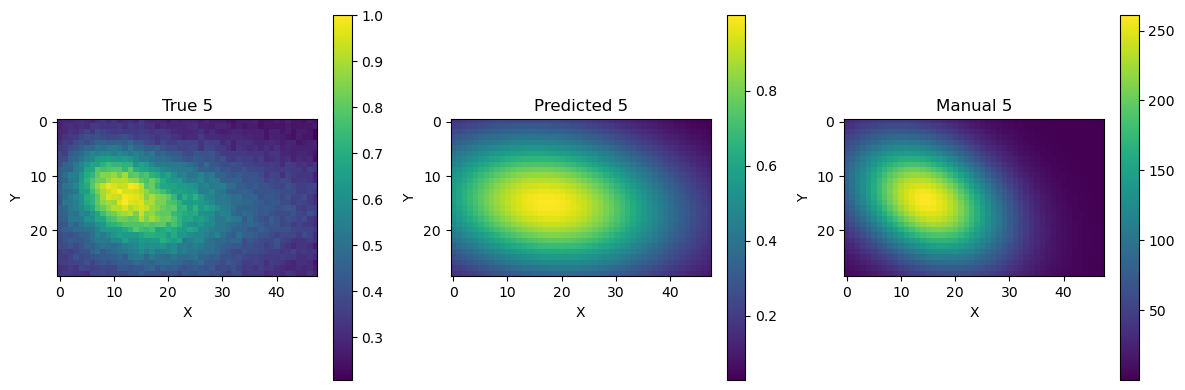

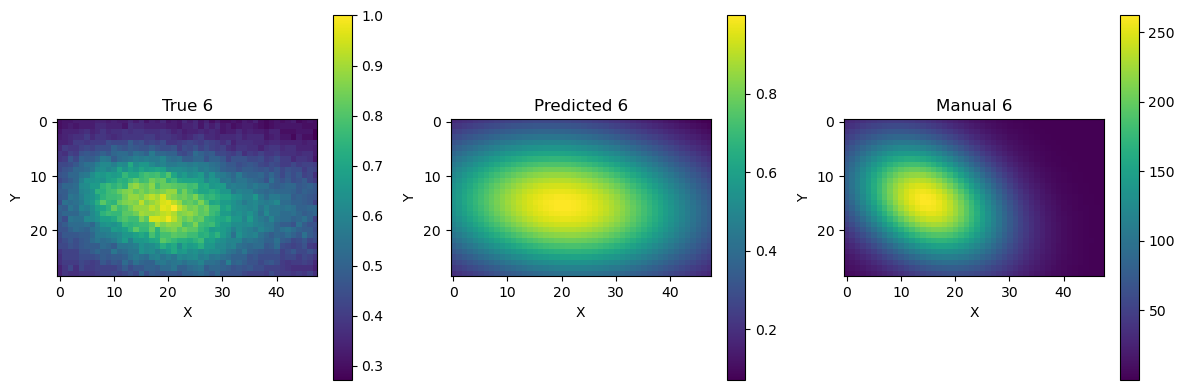

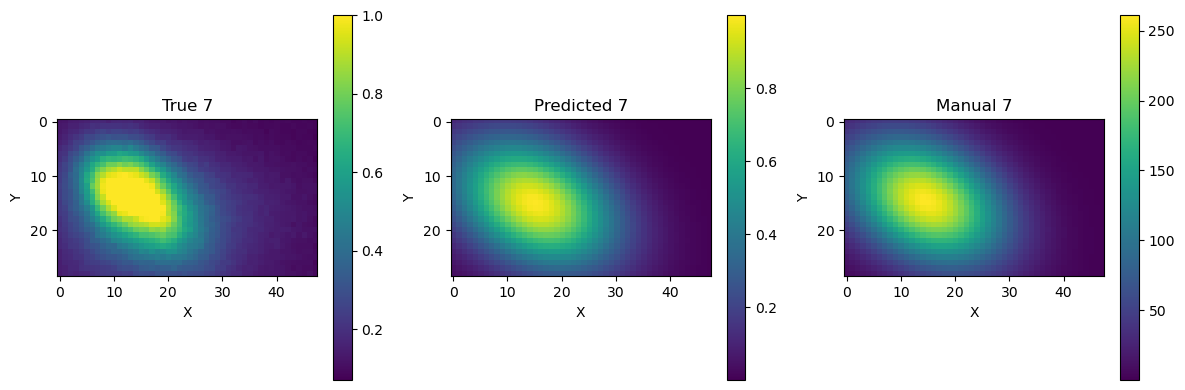

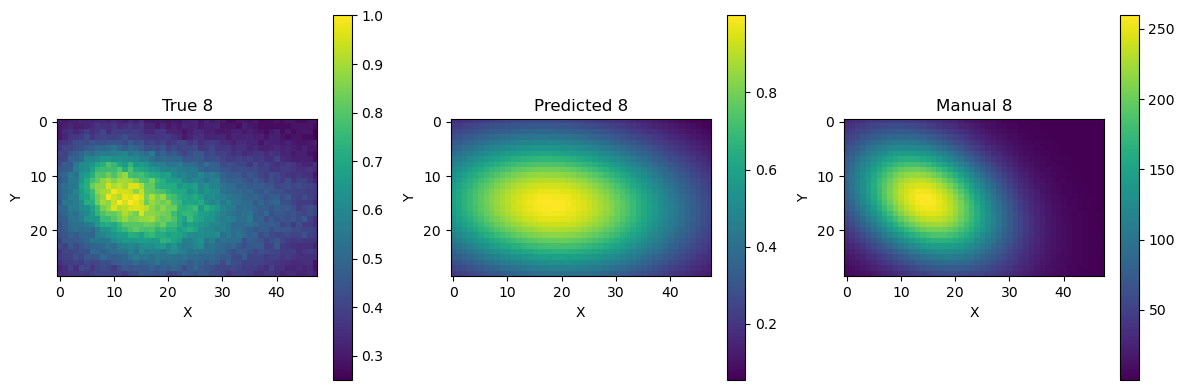

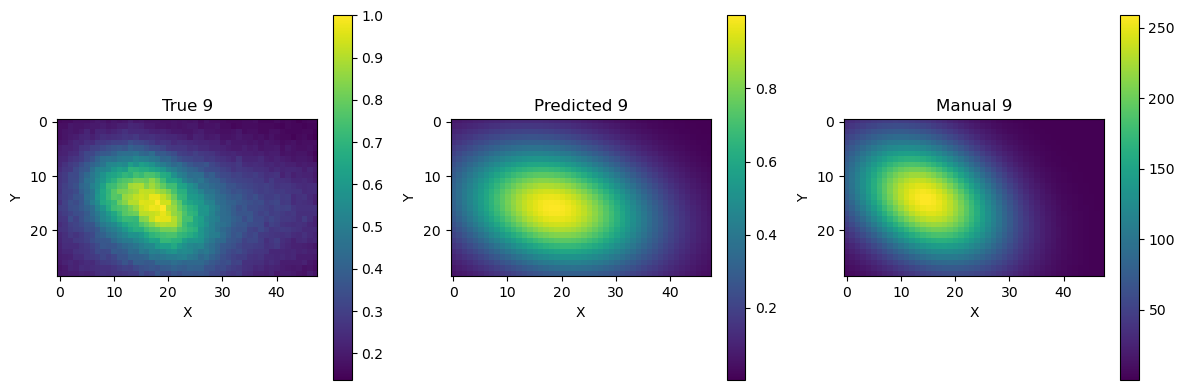

In [14]:

import matplotlib.pyplot as plt

for i in range(10):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    # Plot true image
    im0 = axs[0].imshow(data[i,0])
    axs[0].set_title(f'True {i}')
    axs[0].set_xlabel('X')
    axs[0].set_ylabel('Y')
    fig.colorbar(im0, ax=axs[0])

    # Plot predicted image
    im1 = axs[1].imshow(outputs[i, 0].detach().cpu().numpy().squeeze())
    axs[1].set_title(f'Predicted {i}')
    axs[1].set_xlabel('X')
    axs[1].set_ylabel('Y')
    fig.colorbar(im1, ax=axs[1])

    # Plot manual image
    im2 = axs[2].imshow(manual_im[i])
    axs[2].set_title(f'Manual {i}')
    axs[2].set_xlabel('X')
    axs[2].set_ylabel('Y')
    fig.colorbar(im2, ax=axs[2])

    # Adjust the layout and spacing
    plt.tight_layout()

    # Save the figure
    plt.savefig(f'OutputData/images_{i}.png')

    # Display the figure
    plt.show()



In [16]:
import torch
# from your_lenet5_model_file import LeNet5

# Create an instance of your LeNet5 model
# net = LeNet5(GaussianGenerator((48,29)).float(),5).cuda().float()

model = LeNet5(GaussianGenerator((48,29)).float(),5)  # Replace num_classes with the appropriate number for your task

# Count the number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

for name, param in model.named_parameters():
    print(f"Layer: {name}, Shape: {param.shape}, Parameters: {param.numel()}")

Total number of parameters: 6269
Layer: layer1.0.weight, Shape: torch.Size([6, 1, 5, 5]), Parameters: 150
Layer: layer1.0.bias, Shape: torch.Size([6]), Parameters: 6
Layer: layer1.1.weight, Shape: torch.Size([6]), Parameters: 6
Layer: layer1.1.bias, Shape: torch.Size([6]), Parameters: 6
Layer: layer2.0.weight, Shape: torch.Size([16, 6, 5, 5]), Parameters: 2400
Layer: layer2.0.bias, Shape: torch.Size([16]), Parameters: 16
Layer: layer2.1.weight, Shape: torch.Size([16]), Parameters: 16
Layer: layer2.1.bias, Shape: torch.Size([16]), Parameters: 16
Layer: fc.weight, Shape: torch.Size([48, 48]), Parameters: 2304
Layer: fc.bias, Shape: torch.Size([48]), Parameters: 48
Layer: fc1.weight, Shape: torch.Size([24, 48]), Parameters: 1152
Layer: fc1.bias, Shape: torch.Size([24]), Parameters: 24
Layer: fc2.weight, Shape: torch.Size([5, 24]), Parameters: 120
Layer: fc2.bias, Shape: torch.Size([5]), Parameters: 5
